In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [5]:
np.random.seed(42)

In [6]:
class FastBoard:
    def __init__(self, N, board=None):
        self.N = N
        self.energies = []
        
        if board is not None:
            self.board = board.copy()
        else:
            #self.board = np.random.randint(0, N, size=(N, N))
            self.board = np.zeros((N, N), dtype=int)
        self.offset = N
        self.counters = {
            'row_x': np.zeros((N, N), dtype=int),
            'row_y': np.zeros((N, N), dtype=int),
            'diag_xy_sum': np.zeros((N, 2*N), dtype=int),
            'diag_xy_diff': np.zeros((N, 2*N), dtype=int),
            'diag_xz_sum': np.zeros((N, 2*N), dtype=int),
            'diag_xz_diff': np.zeros((N, 2*N), dtype=int),
            'diag_yz_sum': np.zeros((N, 2*N), dtype=int),
            'diag_yz_diff': np.zeros((N, 2*N), dtype=int),
            'space_1': np.zeros((2*N, 2*N), dtype=int),
            'space_2': np.zeros((2*N, 2*N), dtype=int),
            'space_3': np.zeros((2*N, 2*N), dtype=int),
            'space_4': np.zeros((2*N, 2*N), dtype=int),
        }
        
        self.current_energy = 0
        self._compute_initial_energy()
        self.energies.append(self.current_energy)

    def step(self, temperature, n=1):
        """
        Performs n Metropolis-Hastings steps.
        """
        if isinstance(temperature, (int, float)):
            temps = [temperature] * n
        else:
            temps = temperature

        for i in range(n):
            x = np.random.randint(self.N)
            y = np.random.randint(self.N)
            current_z = self.board[x, y]
            new_z = np.random.randint(self.N)

            if current_z == new_z:
                self.energies.append(self.current_energy)
                continue

            dE_remove = self._get_energy_change(x, y, current_z, -1) 
            dE = self._calculate_transition_delta(x, y, current_z, new_z)


            if dE < 0 or np.random.rand() < np.exp(-dE / temps[i]):
                self._update_counters(x, y, current_z, -1)
                self._update_counters(x, y, new_z, 1)
                self.board[x, y] = new_z
                self.current_energy += dE

            self.energies.append(self.current_energy)

    def _calculate_transition_delta(self, x, y, old_z, new_z):
        """
        Calculates dE without modifying state.
        dE = (Cost of new pos) - (Cost of old pos)
        """
        loss = self._sum_conflicts(x, y, old_z) - 12
        gain = self._sum_conflicts(x, y, new_z)
        return gain - loss

    def _sum_conflicts(self, x, y, z):
        """Returns total queens sharing lines with (x,y,z) from current counters."""
        off = self.offset
        total = 0
        total += self.counters['row_x'][y, z]
        total += self.counters['row_y'][x, z]
        total += self.counters['diag_xy_sum'][z, x + y]
        total += self.counters['diag_xy_diff'][z, x - y + off]
        total += self.counters['diag_xz_sum'][y, x + z]
        total += self.counters['diag_xz_diff'][y, x - z + off]
        total += self.counters['diag_yz_sum'][x, y + z]
        total += self.counters['diag_yz_diff'][x, y - z + off]
        total += self.counters['space_1'][x - y + off, y - z + off]
        total += self.counters['space_2'][x - y + off, y + z]
        total += self.counters['space_3'][x + y, y - z + off]
        total += self.counters['space_4'][x + y, y + z]
        return total

    def _update_counters(self, x, y, z, delta):
        """Updates internal counters when a queen is added (+1) or removed (-1)."""
        off = self.offset
        self.counters['row_x'][y, z] += delta
        self.counters['row_y'][x, z] += delta
        self.counters['diag_xy_sum'][z, x + y] += delta
        self.counters['diag_xy_diff'][z, x - y + off] += delta
        self.counters['diag_xz_sum'][y, x + z] += delta
        self.counters['diag_xz_diff'][y, x - z + off] += delta
        self.counters['diag_yz_sum'][x, y + z] += delta
        self.counters['diag_yz_diff'][x, y - z + off] += delta
        
        self.counters['space_1'][x - y + off, y - z + off] += delta
        self.counters['space_2'][x - y + off, y + z] += delta
        self.counters['space_3'][x + y, y - z + off] += delta
        self.counters['space_4'][x + y, y + z] += delta

    def _compute_initial_energy(self):
        """One-time expensive setup (O(N^2))."""
        self.current_energy = 0
        for key in self.counters:
            self.counters[key].fill(0)

        for x in range(self.N):
            for y in range(self.N):
                z = self.board[x, y]
                self.current_energy += self._sum_conflicts(x, y, z)
                self._update_counters(x, y, z, 1)
    
    def _get_energy_change(self, x, y, z, delta):
        """Helper to compute energy delta if we add/remove queen at x,y,z."""
        count = self._sum_conflicts(x, y, z)
        if delta == -1: return -(count - 12)
        if delta == 1: return count
        return 0

    def get_3d_board(self):
        """Returns the full NxNxN boolean board for visualization."""
        b = np.zeros((self.N, self.N, self.N), dtype=int)
        for x in range(self.N):
            for y in range(self.N):
                b[x, y, self.board[x, y]] = 1
        return b

In [12]:
def run_ensemble(N, steps, temp_schedule, runs=5):
    """
    Runs the simulation 'runs' times and returns the average energy history.
    """
    all_energies = []
    
    for r in tqdm(range(runs)):
        board = FastBoard(N)
        board.step(temp_schedule, n=steps)
        all_energies.append(board.energies)
        
    # Average across runs (axis 0)
    avg_energies = np.mean(np.array(all_energies), axis=0)
    return avg_energies

def average_run(N, steps, runs, t_annealing=None, t_constant=0.5):
    """
    Tasks 1 & 2: Plot Energy vs Time and Compare Annealing vs Constant Temp.
    """
    
    if t_annealing is None:
        t_annealing = np.linspace(3, 0.1, steps)

    # Run simulations
    print(f"  Simulating Annealing (N={N})...")
    e_anneal = run_ensemble(N, steps, t_annealing, runs=runs)
    
    print(f"  Simulating Constant Temp (N={N})...")
    e_const = run_ensemble(N, steps, t_constant, runs=runs)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(e_anneal, label='Simulated Annealing', color='red')
    plt.plot(e_const, label=f'Constant Temp (T={t_constant})', color='blue', alpha=0.6)
    
    plt.title(f"Average Energy Optimization (N={N}, {runs} runs)")
    plt.xlabel("Step")
    plt.ylabel("Energy (Collisions)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def compare_N(n_values, steps, repeats=10, t_schedule=None):
    """
    Tasks 3 & 4: Minimal Energy vs N.
    """

    min_energies = []
    if t_schedule is None:
        t_schedule = np.linspace(5, 0.5, steps)
    
    for N in tqdm(n_values, desc="Testing N sizes"):
        best_e_for_N = float('inf')
        for _ in range(repeats):
            board = FastBoard(N)
            board.step(t_schedule, n=steps)
            if min(board.energies) < best_e_for_N:
                best_e_for_N = min(board.energies)
            if best_e_for_N == 0:
                break
        min_energies.append(best_e_for_N)
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, min_energies, marker='o', linestyle='-', color='purple')
    
    zeros = [n for n, e in zip(n_values, min_energies) if e == 0]
    if zeros:
        print(f"Perfect solutions found for N = {zeros}")
        
    plt.title("Minimal Energy Reached vs. Board Size N")
    plt.xlabel("N (Board Size NxNxN)")
    plt.ylabel("Minimal Energy Found")
    plt.xticks(n_values)
    plt.grid(True, alpha=0.3)
    
    plt.show()
    
    #print min energies in a tab
    print("N\tMin Energy")
    for n, e in zip(n_values, min_energies):
        print(f"{n}\t{e}")

  Simulating Annealing (N=11)...


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


  Simulating Constant Temp (N=11)...


100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


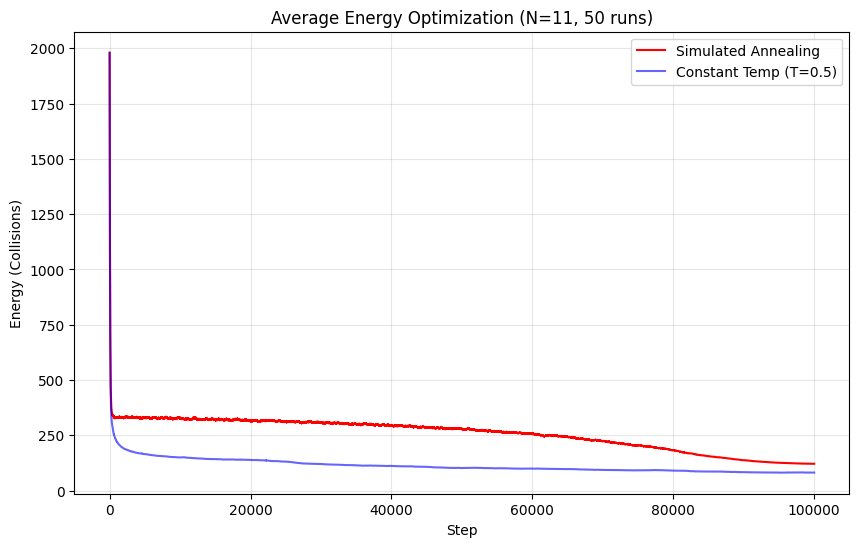

In [13]:
steps = 100000
runs = 50
N = 11
average_run(N, steps, runs, t_annealing=np.linspace(3, 0.1, steps), t_constant=0.5)

Testing N sizes: 100%|██████████| 18/18 [04:12<00:00, 14.03s/it]

Perfect solutions found for N = [11]


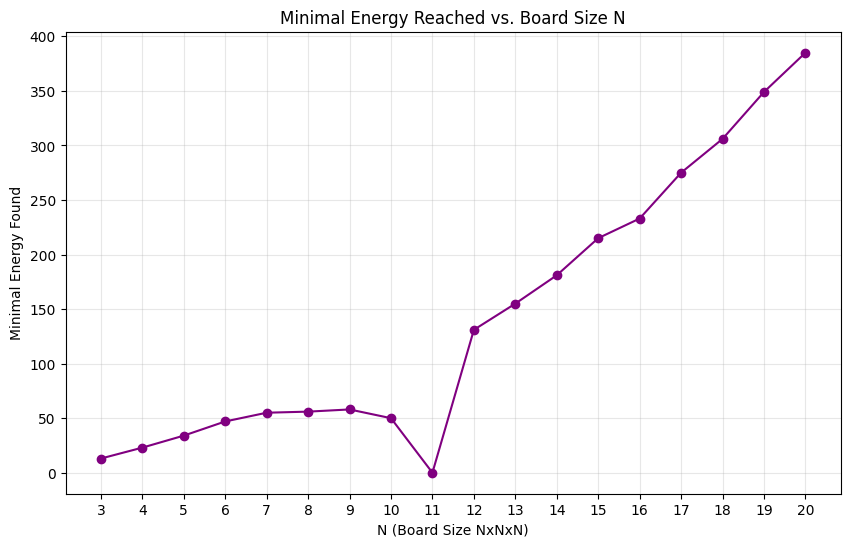

N	Min Energy
3	13
4	23
5	34
6	47
7	55
8	56
9	58
10	50
11	0
12	131
13	155
14	181
15	215
16	233
17	275
18	306
19	349
20	385


In [14]:
steps = 500000
compare_N(range(3,21), steps, 5, t_schedule=np.linspace(3, 0.1, steps))